In [1]:
import cfbd
import datetime
import numpy as np
import pandas as pd

In [2]:
# configure API key
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = 'YOUR_API_KEY_HERE'
configuration.api_key_prefix['Authorization'] = 'Bearer'

# instantiate a games API instance
api_config = cfbd.ApiClient(configuration)
games_api = cfbd.GamesApi(cfbd.ApiClient(configuration))

In [3]:
def date_sort(game):
    game_date = datetime.datetime.strptime(game['start_date'], "%Y-%m-%dT%H:%M:%S.000Z")
    return game_date

def elo_sort(team):
    return team['elo']

def get_expected_score(rating, opp_rating):
    exp = (opp_rating - rating) / 400
    return 1 / (1 + 10**exp)

def get_new_elos(home_rating, away_rating, margin):
    k = 25
    
    # score of 0.5 for a tie
    home_score = 0.5
    if margin > 0:
        # score of 1 for a win
        home_score = 1
    elif margin < 0:
        #score of 0 for a loss
        home_score = 0
    
    # get expected home score
    expected_home_score = get_expected_score(home_rating, away_rating)
    # multiply difference of actual and expected score by k value and adjust home rating
    new_home_score = home_rating + k * (home_score - expected_home_score)
        
    # repeat these steps for the away team
    # away score is inverse of home score
    away_score = 1 - home_score
    expected_away_score = get_expected_score(away_rating, home_rating)
    new_away_score = away_rating + k * (away_score - expected_away_score)
    
    # return a tuple
    return (round(new_home_score), round(new_away_score))

In [4]:
print(get_expected_score(1500, 1500))
print(get_expected_score(1400, 1500))
print(get_expected_score(2000, 1500))

0.5
0.35993500019711494
0.9467597847979775


In [5]:
games = []

for year in range(2000, 2022):
    response = games_api.get_games(year=year)
    games = [*games, *response]
    
games = [dict(
            start_date=g.start_date,
            home_team=g.home_team,
            home_conference=g.home_conference,
            home_points=g.home_points,
            away_team=g.away_team,
            away_conference=g.away_conference,
            away_points=g.away_points
            ) for g in games if g.home_points is not None and g.away_points is not None]
games.sort(key=date_sort)

In [6]:
# dict object to hold current Elo rating for each team
teams = dict()

# loop through games in order
for game in games:
    
    # get current rating for home team
    if game['home_team'] in teams:
        home_elo = teams[game['home_team']]
    elif game['home_conference'] is not None:
        # if no rating, set initial rating to 1500 for FBS teams
        home_elo = 1500
    else:
        # otherwise, set initial rating to 1200 for non-FBS teams
        home_elo = 1200

    # get current rating for away team
    if game['away_team'] in teams:
        away_elo = teams[game['away_team']]
    elif game['away_conference'] is not None:
        # if no rating, set initial rating to 1500 for FBS teams
        away_elo = 1500
    else:
        # otherwise, set initial rating to 1200 for non-FBS teams
        away_elo = 1200
        
    # calculate score margin from game
    margin = game['home_points'] - game['away_points']
    
    # get new elo ratings
    new_elos = get_new_elos(home_elo, away_elo, margin)
    
    # set pregame elos on game dict
    game['pregame_home_elo'] = home_elo
    game['pregame_away_elo'] = away_elo
    
    # set postgame elos on game dict
    game['postgame_home_elo'] = new_elos[0]
    game['postgame_away_elo'] = new_elos[1]
    
    # set current elo values in teams dict
    teams[game['home_team']] = new_elos[0]
    teams[game['away_team']] = new_elos[1]
    

In [7]:
end_elos = [dict(team=key, elo=teams[key]) for key in teams]
end_elos.sort(key=elo_sort, reverse=True)

end_elos

[{'team': 'Alabama', 'elo': 2063},
 {'team': 'Ohio State', 'elo': 2001},
 {'team': 'Oklahoma', 'elo': 1962},
 {'team': 'Clemson', 'elo': 1955},
 {'team': 'Georgia', 'elo': 1902},
 {'team': 'Notre Dame', 'elo': 1872},
 {'team': 'LSU', 'elo': 1828},
 {'team': 'Auburn', 'elo': 1786},
 {'team': 'Penn State', 'elo': 1781},
 {'team': 'Oregon', 'elo': 1777},
 {'team': 'Florida', 'elo': 1777},
 {'team': 'Michigan', 'elo': 1777},
 {'team': 'Oklahoma State', 'elo': 1774},
 {'team': 'Texas A&M', 'elo': 1762},
 {'team': 'Iowa', 'elo': 1755},
 {'team': 'USC', 'elo': 1750},
 {'team': 'Wisconsin', 'elo': 1735},
 {'team': 'Utah', 'elo': 1721},
 {'team': 'Texas', 'elo': 1713},
 {'team': 'Stanford', 'elo': 1707},
 {'team': 'Washington', 'elo': 1699},
 {'team': 'Cincinnati', 'elo': 1683},
 {'team': 'Michigan State', 'elo': 1682},
 {'team': 'Boise State', 'elo': 1681},
 {'team': 'Miami', 'elo': 1667},
 {'team': 'BYU', 'elo': 1666},
 {'team': 'Iowa State', 'elo': 1657},
 {'team': 'Kentucky', 'elo': 1655},


In [8]:
import matplotlib.pyplot as plt

# This is the styling I use. Check out other themes here: https://matplotlib.org/3.2.1/gallery/style_sheets/style_sheets_reference.html
plt.style.use('fivethirtyeight')

# Graph sizing
plt.rcParams["figure.figsize"] = [20,10]

In [9]:
def generate_chart(team):
    team_games = []
    for game in games:
        if game['home_team'] == team:
            team_games.append(dict(start_date=game['start_date'], elo=game['postgame_home_elo']))
        
        if game['away_team'] == team:
            team_games.append(dict(start_date=game['start_date'], elo=game['postgame_away_elo']))
            
    df = pd.DataFrame.from_records(team_games)
    
    fig, ax = plt.subplots()
    #plt.ylim([0, 2500])
    ax.plot(df.index, df['elo'])

    ax.set(xlabel='Game No.', ylabel='Elo Rating',
           title="Historical Elo Rating - {0}".format(team))
    
    plt.show()
    

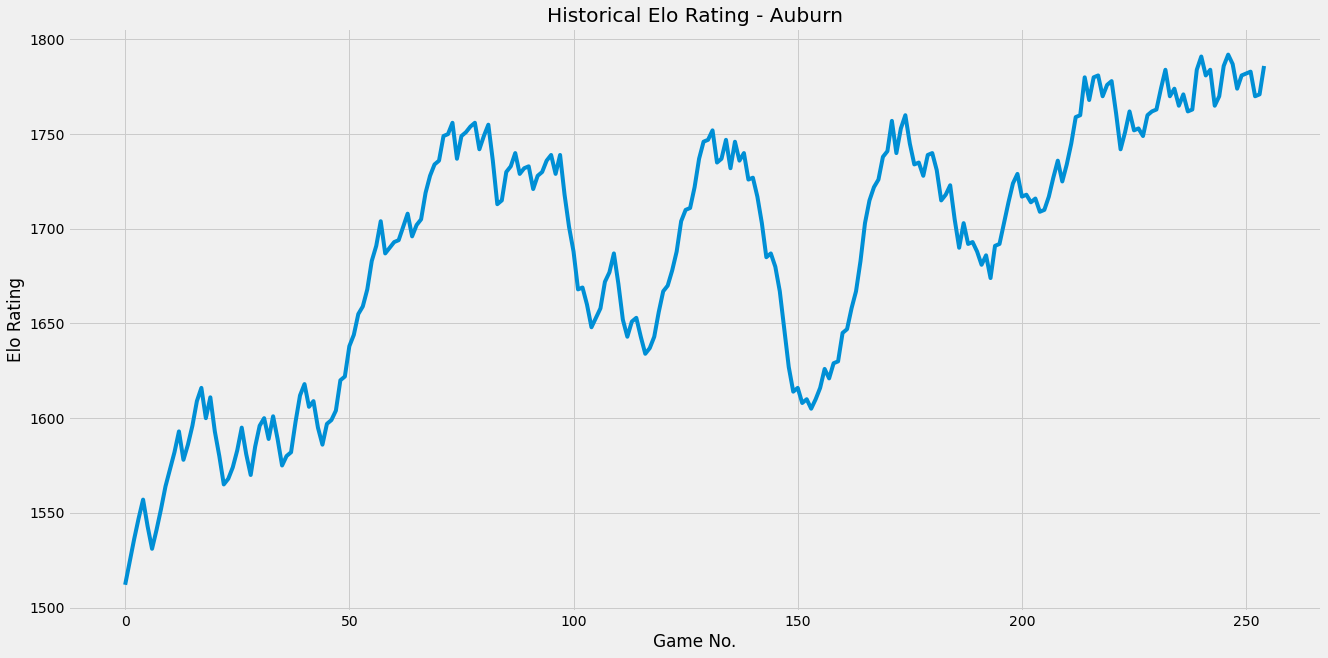

In [10]:
generate_chart('Auburn')

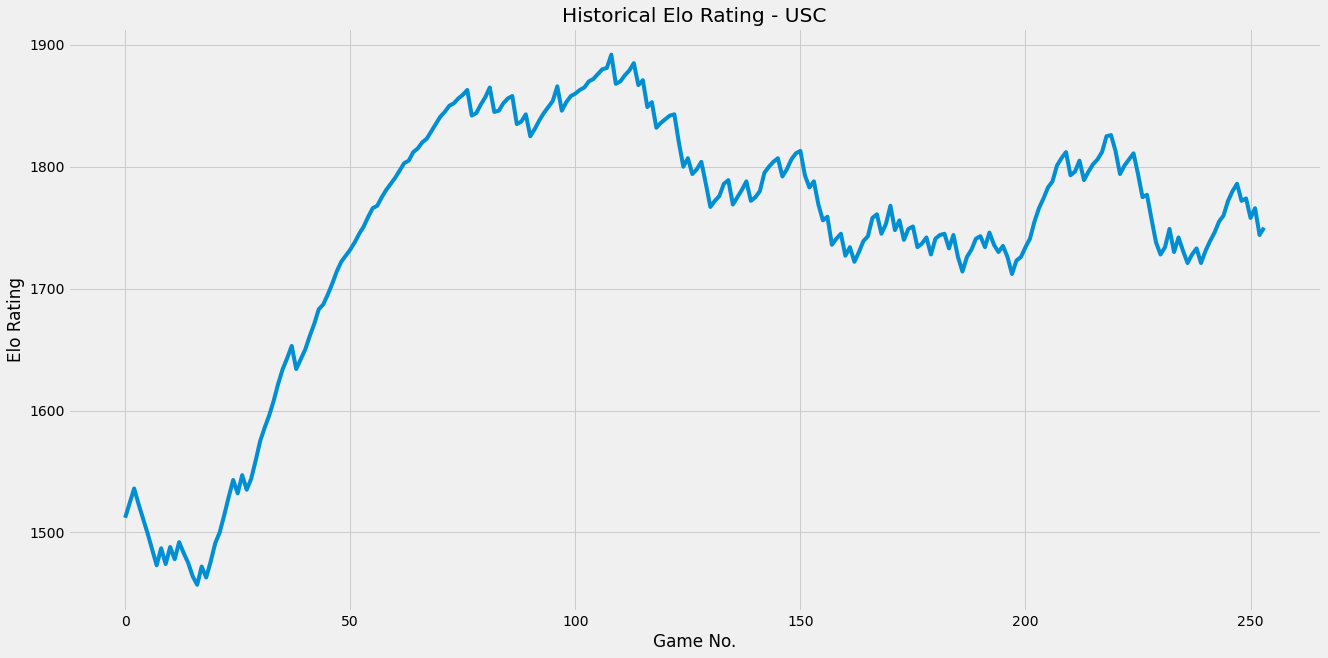

In [11]:
generate_chart('USC')